In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-image opencv-python-headless

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import pandas as pd
import os

In [20]:
image_path = "/content/drive/MyDrive/OneDrive_1_6-24-2025/Test_2/BRIGHTFIELD_16358_02112020_1358.jpg"

# Load 16-bit TIFF and normalize to 8-bit
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
if img is None:
    raise ValueError("Image not found. Check path.")
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [21]:
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(img_norm, (11, 11), 0)

# Threshold using Otsu's method (inverse binary for dark objects)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Morphological cleaning
clean = morphology.remove_small_objects(thresh.astype(bool), min_size=500)
clean = morphology.binary_closing(clean, morphology.disk(5))

In [22]:
# Label connected regions
labels = measure.label(clean)
props = measure.regionprops(labels)

# Prepare output image and results list
output_img = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2BGR)
results = []

for prop in props:
    if prop.area > 10000:
        y0, x0 = prop.centroid
        coords = prop.coords

        # Create binary mask for this region
        mask = np.zeros_like(clean, dtype=np.uint8)
        mask[coords[:, 0], coords[:, 1]] = 255

        # Find contour of the object
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0:
                continue
            circularity = 4 * np.pi * area / (perimeter ** 2)

            # Draw contour on the image
            cv2.drawContours(output_img, [cnt], -1, (0, 0, 255), 2)

            # Save measurements
            results.append({
                "centroid_x": round(x0, 2),
                "centroid_y": round(y0, 2),
                "area": round(area, 2),
                "perimeter": round(perimeter, 2),
                "circularity": round(circularity, 4)
            })

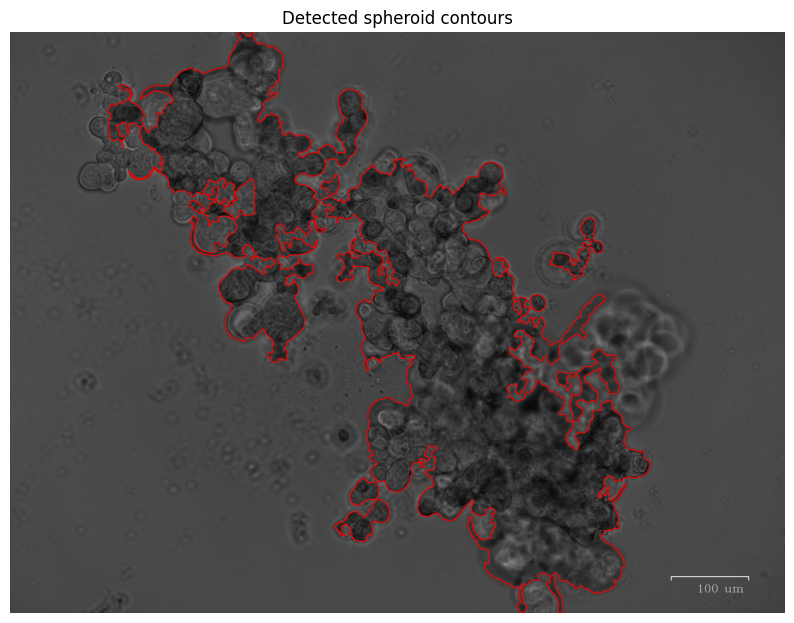

,centroid_x,centroid_y,area,perimeter,circularity
0,792.92,511.01,337810.0,9827.63,0.0440
1,1602.14,1204.49,771243.5,14026.53,0.0493
2,1904.15,735.58,10521.5,985.22,0.1362
3,1186.35,1605.43,16909.0,1015.95,0.2059


In [23]:
# Show detection result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Detected spheroid contours")
plt.axis("off")
plt.show()

# Create and show DataFrame
results_df = pd.DataFrame(results)
results_df

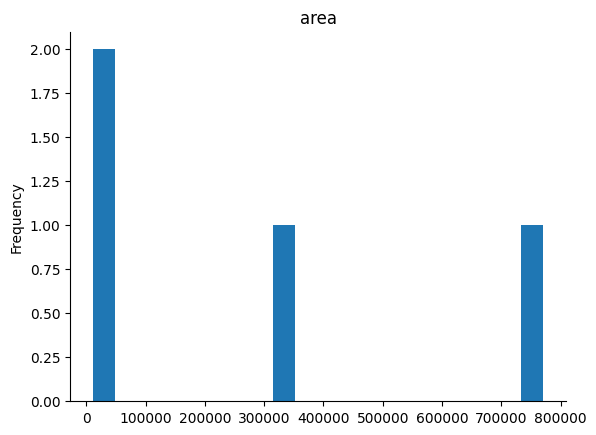

In [24]:
# @title area

from matplotlib import pyplot as plt
results_df['area'].plot(kind='hist', bins=20, title='area')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Change output path and file name as needed
csv_output_path = "/content/drive/My Drive/Imaging/detected_spheroids_metrics.csv"
results_df.to_csv(csv_output_path, index=False)
print(f"Saved to: {csv_output_path}")